# Analyzing the Success of Kickstarter Projects


## Team members and contributions

Note: Everyone contributed to writing and editing the project proposal.
1. Christopher Kagoo (PID: A13737520)
    - Analysis of all the data visualizations and coming out with conclusions.
2. Jocelyn Wei (PID: A13750733)
    - Editing, building the classifier, and large scale text integration.
3. Kaustubh Lall (PID: A13413116)
    - Dataset/idea, editing, metrics, and classifier research/visualization.
4. Manik Narang (PID: A13711430)
    - Data cleaning, data visualization, and data privacy.
5. Nidhi Bangari (PID: A13440797)
    - Data visualization, metrics, analysis and data description.

<a id='introduction'></a>
## Introduction and Background

Kickstarter is a popular online resource used by ambitious entrepreneurs to pitch their products to the wide audience of the internet in an attempt to obtain funding. When someone launches a project on Kickstarter, the most important question for them is, "Will my project reach its goal before the deadline I've set?" And also, "What can I do to make my project succeed?"

Although human intuition might be able to estimate a project's potential, we were interested in taking a data driven approach to addressing these questions, using the plethora of publicly available information from each Kickstarter project. Based on patterns of success from previous Kickstarter projects, would it be possible to estimate and/or maximize the success of one's potential Kickstarter fundraiser?

To answer this question, we implemented two different data science techniques. First, we used the data from all previous Kickstarter projects and trained a classifier to predict if a potential project would be successful. Second, we manually visualized the data, analyzing the correlations of what could likely be significant factors in the success of a project, using statistics and data visualization. This would allow us to determine if there were patterns in the success of Kickstarter projects that prospective project launchers could take advantage of in order to maximize their likelihood of success.

#### Hypothesis
We hypothesized that it would be possible to train a classifier that would be able to predict the success of a project with a decent (>70%) amount of accuracy. At the least, the classifier should be able to determine if projects are aiming too high with their goals compared to other projects in their categories with similar durations.

We also hypothesized that we would be able to find trends in Kickstarter projects that were successful. Specifically, a project's category, duration of campaign, and goal amount would play a significant factor in its success or failure.


## Overview

[Introduction and Background](#introduction)<br>

[Data Description](#data)<br>
[Data Cleaning/Pre-processing](#clean)<br>

[Inputs for the Classifier](#class_inputs)<br>
[Classifier Design](#class_design)<br>
[Classifier Analysis](#class_analysis)<br>

[Data Analysis and Visualization](#vis_data)

[Privacy/Ethics Considerations](#ethics)<br>
[Conclusions and Discussion](#closing)


In [1]:
# Imports here
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# sklearn models
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from datetime import datetime
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use('ggplot') # make plots look better

In [2]:
# Read the csv
df = pd.read_csv("ks-projects-201801.csv")


<a id='data'></a>
# Data Description

- `ID`			        : Unique Kickstarter ID 
- `name`			    : Name of proposal
- `category` 		    : Specific category of project
- `main_category`	    : Parent Categories
- `currency` 		    : Original currency
- `deadline` 		    : Project expiry date
- `goal` 			    : Goal of product in respective currency
- `launched` 		    : Project launch date
- `pledged` 		    : Amount of pledged before deadline
- `state` 			    : State of project -- fail, success, ...
- `backers` 		    : Number of backers for a project
- `country` 		    : Country of project
- `usd pledged`  		: Pledged amount converted to USD (by Kickstarter)
- `usd_pledged_real` 	: Pledged amount converted to USD (by Fixer.io)
- `usd_goal_real`		: Goal amount converted to USD (by Fixer.io)

We found the dataset on kaggle.com: https://www.kaggle.com/kemical/kickstarter-projects. This data was scraped by a Kaggle user, Kemical. This user identifies as a crowdfunding enthusiast, who collected the data from the Kickstarter platform for public use - particularly wanting someone to create a model to predict if a project would be successful before its release.

This dataset has all the Kickstarter projects’ data up until January 2018. The description of each individual column has been written above. The data has been pre-anonymized to remove names and other identifying information.

These are the possible categories and states for the Kickstarter Projects:

In [3]:
num_categories = df["main_category"].unique()
num_state = df["state"].unique()

print("Major categories: \n" + ', '.join(num_categories))
print("\nStates: \n" + ', '.join(num_state))

Major categories: 
Publishing, Film & Video, Music, Food, Design, Crafts, Games, Comics, Fashion, Theater, Art, Photography, Technology, Dance, Journalism

States: 
failed, canceled, successful, live, undefined, suspended


<a id='clean'></a>
# Data Cleaning/Pre-processing

To clean the data in preparation for building a classifier and visualizing the data, we addressed the following:
- Extraneous columns 
- Calculating "days live" from launch date and deadline
- Removing null data
- Creating  new columns for the classifier

#### Extraneous columns (`usd pledged`)

The dataset we are using contains the following three columns for currency conversion (using January 2018 conversion rates).
- `usd pledged`:       conversion in US dollars of the pledged column (conversion done by kickstarter).
- `usd_pledge_real`:   conversion in US dollars of the pledged column (conversion from Fixer.io API).
- `usd_goal_real`:     conversion in US dollars of the goal column (conversion from Fixer.io API).

We are using the `usd_pledged_real` and `usd_goal_real` columns which have the currency conversions from Fixer.io's API, as of January 2018. We don't need the `usd pledged` column since it is redundant, so we dropped that:

In [4]:
df.drop("usd pledged", axis=1, inplace=True)

#### Calculating "days live" from launch date and deadline

Note: To calculate the number of hours (and then the number of days) each project was in the "live" state, we are assuming that the deadline for each project is 11:59 PM on the date mentioned in the deadline column.

In [5]:
# Just to be sure that no timestamp is null
if (df["deadline"].isnull().any() == True or df["launched"].isnull().any() == True):
    # Should never do this
    raise SystemExit

# Add 23:59:59 stamp in the deadline column so that we can calculate the
# number of hours the project was "live" on kickstarter
df["deadline"] = df["deadline"].loc[0:] + " 23:59:59"

# Now let's calculate the number of hours and days each project was live
hours_live = []
days_live = []
for index, (timestamp1, timestamp2) in enumerate(zip(df["deadline"], df["launched"])):
    ts1 = datetime.strptime(timestamp1, "%Y-%m-%d %H:%M:%S")
    ts2 = datetime.strptime(timestamp2, "%Y-%m-%d %H:%M:%S")
    difference = ts1 - ts2
    days, seconds = difference.days, difference.seconds
    days += (seconds/(3600*24))
    days_live.append(days)
    hours = (days * 24) + (seconds/3600)
    hours_live.append(hours)

# Add number of hours and days in df
hours_live = pd.Series(hours_live)
days_live = pd.Series(days_live)
df["hours_live"] = hours_live
df["days_live"] = days_live

df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,hours_live,days_live
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 23:59:59,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,1533.95,1439.583889,59.491331
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 23:59:59,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,2421.0,30000.00,1478.534444,60.802801
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 23:59:59,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,45000.00,1127.305000,45.985521
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 23:59:59,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,5000.00,761.193333,30.858194
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 23:59:59,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,19500.00,1374.831111,56.642315


#### Null data

We checked if any rows contain null data that needs to be dropped.

In [6]:
# Check for rows having no data
null_data = df[df.isnull().any(axis=1)]

# Print the null_data
null_data

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real,hours_live,days_live
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29 23:59:59,200000.0,2012-01-01 12:35:31,100.0,failed,1,US,100.00,200000.00,1438.815556,59.475324
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06 23:59:59,2000.0,2012-12-19 23:57:48,196.0,failed,12,GB,316.05,3224.97,432.072778,18.001516
309991,648853978,NaN,Product Design,Design,USD,2016-07-18 23:59:59,2500.0,2016-06-18 05:01:47,0.0,suspended,0,US,0.00,2500.00,757.940000,30.790417
338931,796533179,NaN,Painting,Art,USD,2011-12-05 23:59:59,35000.0,2011-11-06 23:55:55,220.0,failed,5,US,220.00,35000.00,696.135556,29.002824


We saw that we just have 4 rows containing null data, and the null data is just the project name. We decided not to drop these rows since we didn't really need project names in our analyses. Even though dropping 4 rows wouldn't significantly affect our dataset, which has 380K rows, we chose to leave these rows in the dataset in order to make our classifier as accurate as possible.

<a id='class_inputs'></a>
## Inputs for the Classifier

The classifier needs inputs known apriori to the launch because the aim is to predict if a given Kickstarter will work. To this effect, we were disbarred from using pledged amounts, number of backers, etc. as input. Thus, we were limited to using the data about the goal, category, main category, country, etc…

It was not clear how useful the information about a Kickstarter project's category, country... was going to be. More specifically, it was uncertain if they would help draw better decision boundaries or instead introduce more error in our data. In order to determine this, we briefly visualized some of our data to help curate our data for use with a classifier.
    
After testing, the subcategory and country appeared to not have a significant effect on the result of the fundraiser, so we simply accounted for the main category of the project in the classifier.

Finally, we used a 80/20 split for training and testing, but also tried 70/30 and 90/10. Experimentally, 80/20 yielded the best and most consistent rate across all tests and classifiers.

The inputs to our classifier are:
- category
- main_category
- goal in USD
- duration (in days)

Our classifier will then output the state (failed or successful).

We decided not to consider suspended, canceled, or undefined projects. 

According to the [Kickstarter FAQ](https://www.kickstarter.com/help/faq/creator+questions), a project is suspended if it is "in violation of Kickstarter rules." Also according to the FAQ, project creators can choose to cancel their Kickstarter campaigns, which cancels funding and immediately voids all pledges.

We were trying to provide a model for projects prior to launch, and cancellation or suspension are outcomes that are dependent on variables outside of the dataset we used. Therefore, predicting either of these outcomes would be beyond the purpose of the classifier.

Before we dropped these rows to reduce the amount of noise that our model has to account for, we took a look at the total number of projects that were suspended or canceled:

In [7]:
print("The possible states for a project are: " + ', '.join(df['state'].unique()))
print("The number of susspended projects are: %d." % df[df['state'] == 'suspended'].shape[0])
print("The number of cancelled projects are: %d" % df[df['state'] == 'canceled'].shape[0])

The possible states for a project are: failed, canceled, successful, live, undefined, suspended
The number of susspended projects are: 1846.
The number of cancelled projects are: 38779


Setting aside the projects that are still live (we used these to test our classifier later), we also dropped any project whose outcome was undefined for some reason.

In [8]:
df = df[df['state'] != "undefined"]
df_live = df[df['state'] == 'live']
df = df[df['state'] != 'live']
df = df[df['state'] != 'canceled']
df = df[df['state'] != 'suspended']


print("After removing undefined, live, cancelled, suspended, we have %d entries." % df.shape[0])

After removing undefined, live, cancelled, suspended, we have 331675 entries.


Since we still had a large number of entries after dropping the cancelled, suspended, and undefined projects, we felt confident in removing these categories from the dataset for our classifier. 

Next, we created two new columns in the dataset callled category_id and main_category_id, to map the categories and main categories to integers that we can use as inputs for our classifier. To do this, we defined a function called cats_to_ids.

In [9]:
arr_of_cats = list(df['category'].unique())
arr_of_main_cats = list(df['main_category'].unique())
arr_of_countries = list(df['country'].unique())

def cats_to_ids(label):
    return arr_of_cats.index(label)

def main_cats_to_ids(label):
    return arr_of_main_cats.index(label)

def countries_to_ids(label):
    return arr_of_countries.index(label)

# apply transforms
df['cat_id'] = df['category'].apply(cats_to_ids)
df['main_cat_id'] = df['main_category'].apply(main_cats_to_ids)
df['country_id'] = df['country'].apply(countries_to_ids)
df['cat_id'].shape, df['main_cat_id'].shape, df['country_id'].shape

((331675,), (331675,), (331675,))

In [10]:
df.describe()

,ID,goal,pledged,backers,usd_pledged_real,usd_goal_real,hours_live,days_live,cat_id,main_cat_id,country_id
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,3.316750e+05,3.316750e+05,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,1.074271e+09,4.425157e+04,1.058400e+04,116.381581,9.943461e+03,4.151000e+04,835.772612,34.389367,40.727628,4.981672,1.616866
std,6.191924e+08,1.117917e+06,1.015917e+05,965.427268,9.673293e+04,1.108930e+06,305.797712,12.723385,33.711020,4.104161,2.687299
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,1.000000e-02,24.242222,1.005046,0.000000,0.000000,0.000000
25%,5.371725e+08,2.000000e+03,5.000000e+01,2.000000,5.000000e+01,2.000000e+03,724.743056,30.088918,16.000000,1.000000,1.000000
50%,1.074573e+09,5.000000e+03,7.820000e+02,15.000000,7.880000e+02,5.000000e+03,749.798889,30.656748,31.000000,4.000000,1.000000
75%,1.609844e+09,1.500000e+04,4.657000e+03,63.000000,4.608000e+03,1.500000e+04,891.091111,36.705955,56.000000,8.000000,1.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,1.663614e+08,2254.206667,92.962639,158.000000,14.000000,22.000000


<a id='class_design'></a>
## Classifier Design

Presented below is some relevant information that was very influential in deciding the design of the classifier. We used seaborn to plot, visualize and gain intuition for our data. This was very important to ensure we were able to build the most robust classifier possible, and provide reliabe results.


    1. We are trying to map from 3-5 input domain to a binary codomain (success, fails).

    2. We have large amounts of data, no GPU-Compute or parallel architecture to do deep learning, or extensive training.
    
Thus, SVM was out of the question, because on a 3e+5 sized dataset, SVM calculations would take forever. We could pre-train and load a model, but it was difficult to use that to justify using SVM over classifiers more suited to this kind of a problem.

##### Random Forest Walk
Random Forest Walk performs extremely well even on large datasets and big input dimensions (purportedly it can scale well even on 100 inputs) thus makes a good candidate. However, its classification may not be well suited to our data, because two successful projects are expected to be similar to each other, so a clustering/grouping approach seems more native. (RFW produces ~65% test accuracy).

##### Gaussian Process 
This is not natively suited for the type because as we have seen, our data has very weak correlation. Since Gaussian is highly statistical, it many not be relevant (<50% accuracy).

##### KNearestNeighbour
This approach actually maps well natively to this classification problem. It is intuitive that successful projects are going to be “similar” to eachother. Thus using 2-5 Nearest neighbour approach, we were able to get good bounds on predictions. While this algorithm is far from perfect, it gives a sanity check on averages.

It is worthwhile to note that KNN underperforms when compared to RFW (~62% test accuracy on KNN) but is far less erratic. It does significantly better job at eliminating outliers, and thus is more suitable as a sanity check.

Using a time-efficient kd-tree implementation for NN searches, we can get a tight bound on runtime, thus this methods scales well to our dataset.

##### Final Notes
It is both prudent and important to note that our data is highly uncorrelated, and it would be nothing short of a miracle if our classifier was able to give predictions without knowing products, simply based on some goal numbers. Since the data is not extremely descriptive, this approach is centered around getting estimates, not deterministic results. It should be treated as such. As we further visualize the data, it should become more clear what modifications we need to take into account for the classifier.


### Visualizing data before creating the classifier

We used a log-scaled plot because we had a huge distribution and would like to analyze trends in the data. The log scales helped us "compress" the data visually and focus on the trends. Some graphs are NOT log scaled, the scale is mentioned per graph.

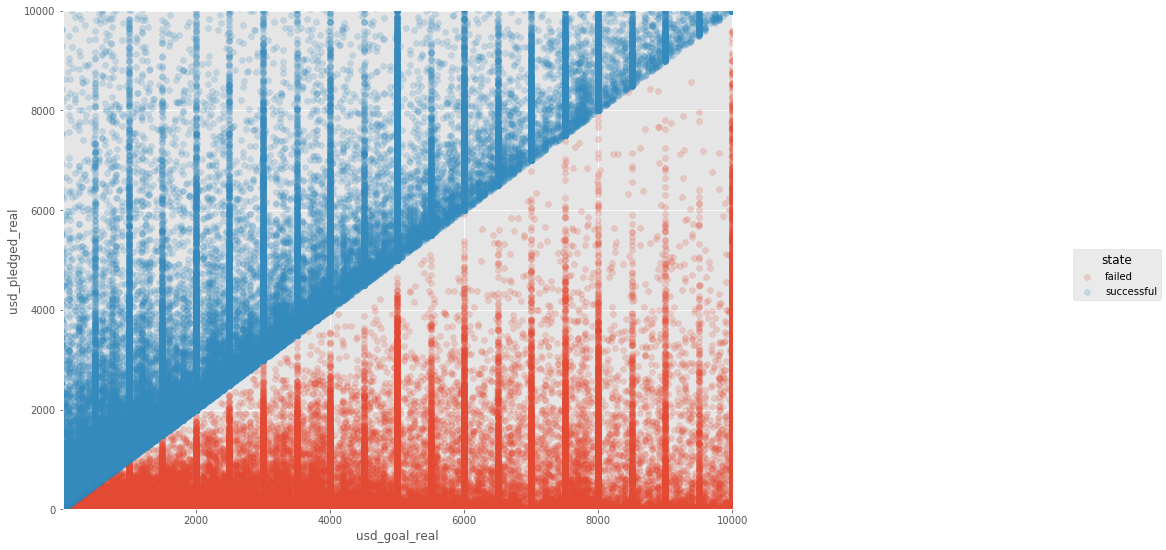

In [11]:
a = sns.FacetGrid(df, hue="state").map(plt.scatter, "usd_goal_real", "usd_pledged_real", alpha=0.2).add_legend()
plt.xlim(1e1, 1e4)
plt.ylim(1e1, 1e4)
a.fig.set_size_inches(20,10)
plt.show()

This graph attempts to express pledged as a function of real. The 'lines' appear because of people's tendencies to use round numbers as goals. Overall, this shows a low-correlated data. Also interesting to notice is the decision boundary at goal=pledged, where the graph turns blue.

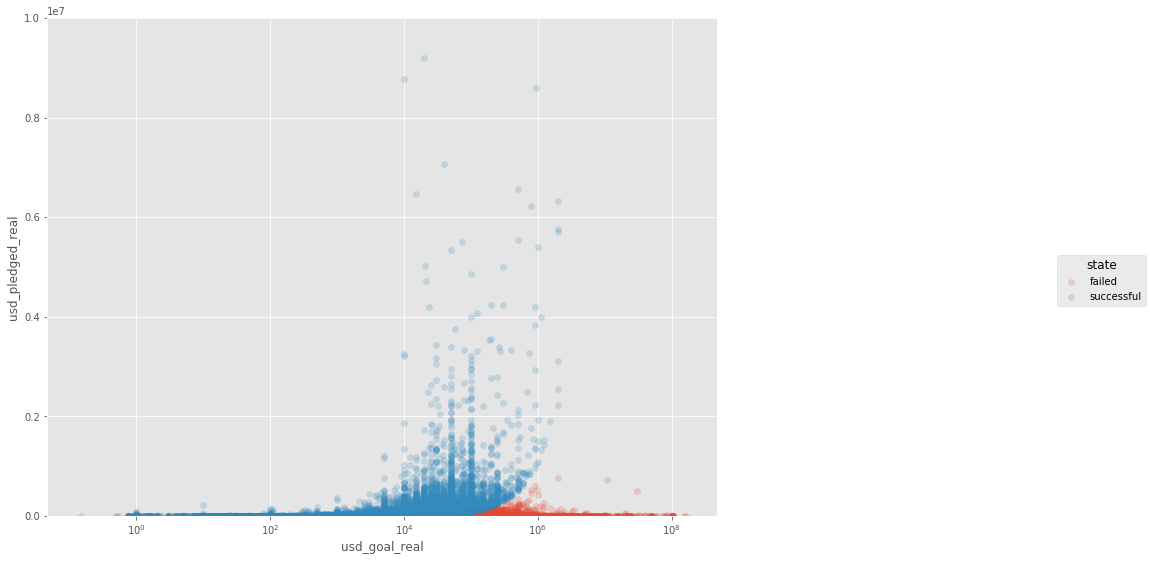

In [12]:
a = sns.FacetGrid(df, hue="state").map(plt.scatter, "usd_goal_real", "usd_pledged_real", alpha=0.2).add_legend()
plt.ylim(1e3, 1e7)
a.fig.set_size_inches(20,10)
a.fig.get_axes()[0].set_xscale('log')
plt.show()

This is a view of a different slice of the graph. X is log-scaled

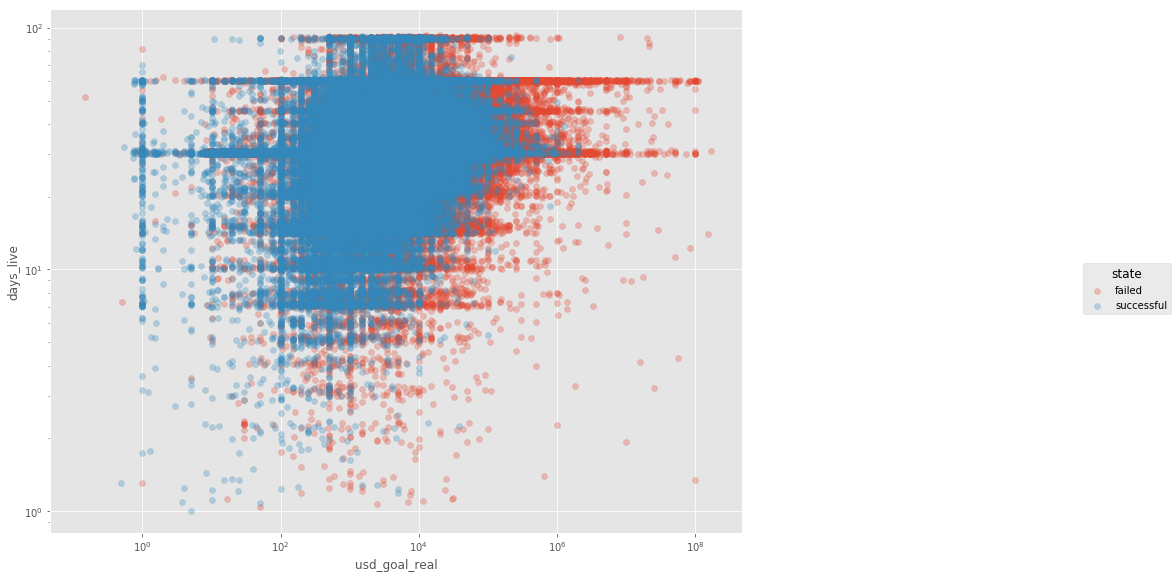

In [13]:
b = sns.FacetGrid(df, hue="state").map(plt.scatter, "usd_goal_real", "days_live", alpha = 0.3).add_legend()
b.fig.get_axes()[0].set_xscale('log')
b.fig.get_axes()[0].set_yscale('log')
b.fig.set_size_inches(20,10)
plt.show()

Days live vs. pledged does not correlate very heavily. However, the ones that fail seem to marginally be shifted to the right. This just shows that not all goals are met and is quite expected.

Now, we will visualize categories. To better visualize, the y-ax will be log-scaled.

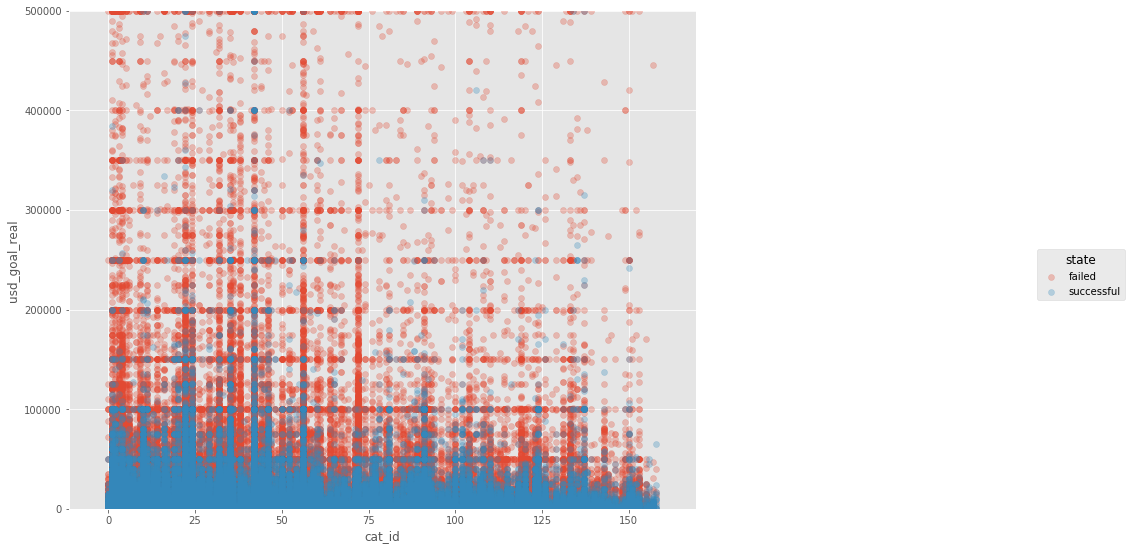

In [14]:
g = sns.FacetGrid(df, hue="state").map(plt.scatter, "cat_id", "usd_goal_real", alpha=0.3).add_legend()
g.fig.set_size_inches(20,10)
plt.ylim(0,0.5*1e6)
plt.show()

This graph shows two things: 
1. Lower goals, independent of categories. 2. Not all categories are the same height.

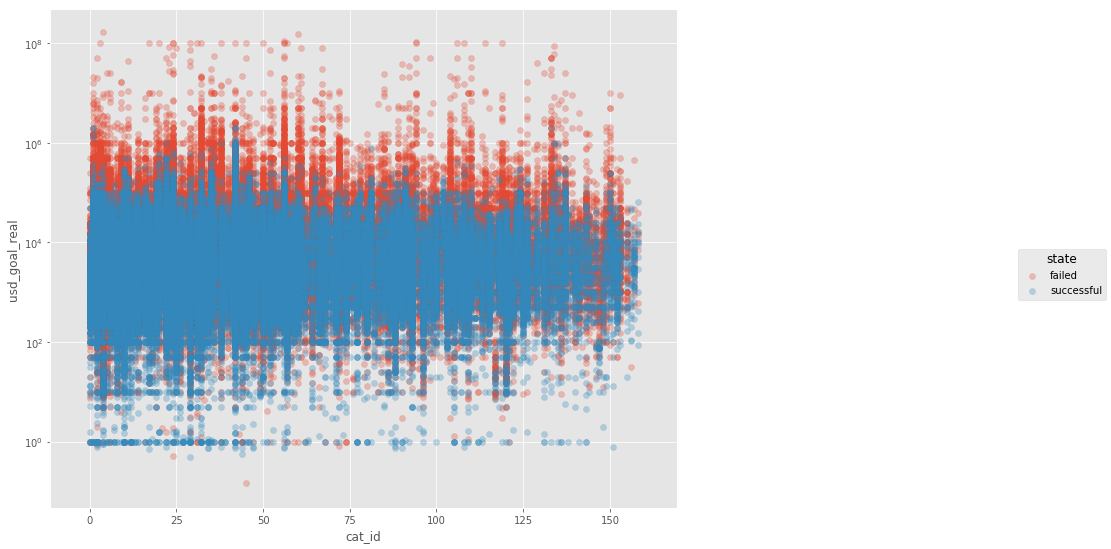

In [15]:
g = sns.FacetGrid(df, hue="state").map(plt.scatter, "cat_id", "usd_goal_real", alpha = 0.3).add_legend()
g.fig.set_size_inches(20,10)
g.fig.get_axes()[0].set_yscale('log')
plt.show()


This graph just helps us scale our visualization of the prior graph.

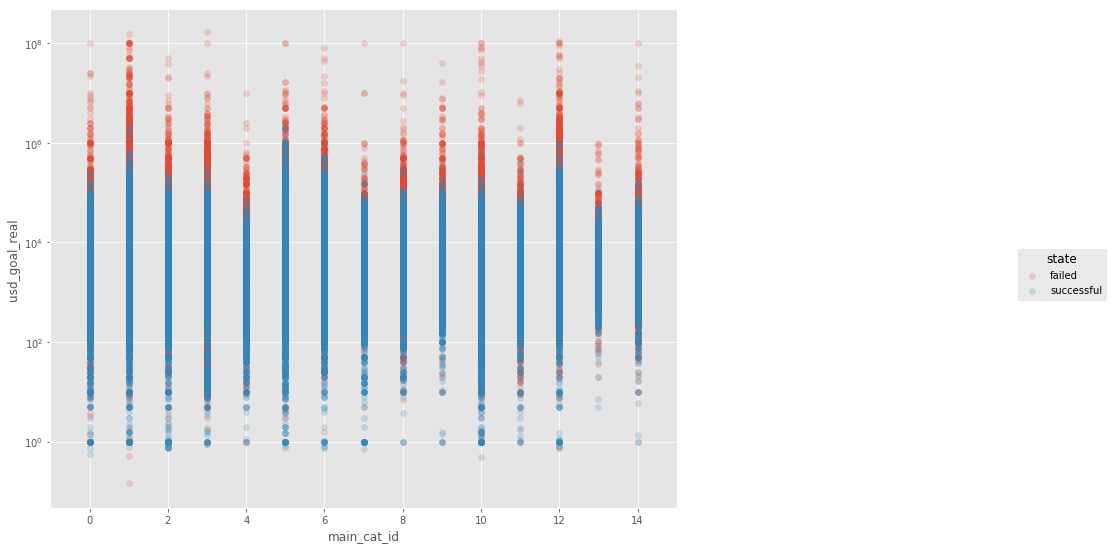

In [16]:
g = sns.FacetGrid(df, hue="state").map(plt.scatter, "main_cat_id", "usd_goal_real", alpha = 0.2).add_legend()
g.fig.get_axes()[0].set_yscale('log')
g.fig.set_size_inches(20,10)
plt.show() 


This graph does the same visualization as the previous graph, except it compresses the number of categories to a smaller dimension.

We then checked for outliers:

In [17]:
print("In our dataset %d projects got funded for >=$10 Million, and %d projects got funded for >=$1 Million." %
     (df[df['pledged'] > 10e6].shape[0], df[df['pledged'] > 1e6].shape[0]))
print("In our dataset %d projects had goals: >=10 Million, and %d goals for >=$1 Million." %
     (df[df['goal'] > 10e6].shape[0], df[df['goal'] > 1e6].shape[0]))
print("The max goal was: ${:,} and the max pledge was: ${:,}.".format(max(df['goal']), max(df['pledged'])))
print("The number of projects that were successful: {:,} and the number failed: {:,}".format(df[df['state'] == 'failed'].shape[0], df[df['state'] == 'successful'].shape[0]))

In our dataset 6 projects got funded for >=$10 Million, and 320 projects got funded for >=$1 Million.
In our dataset 114 projects had goals: >=10 Million, and 894 goals for >=$1 Million.
The max goal was: $100,000,000.0 and the max pledge was: $20,338,986.27.
The number of projects that were successful: 197,719 and the number failed: 133,956


We determined that there were no outliers that needed to be individually addressed, as the outliers seemed meaningful enough to include in our classifier data- they represented the projects which had very high goals and/or got a lot of funding, which we felt would improve our classifier performance by indicating the effect of having such high goals on project outcome, and would help us determine the likelihood of getting a lot of funding from a project. 

We then proceeded to train the classifier: 

In [18]:
df.corr()

,ID,goal,pledged,backers,usd_pledged_real,usd_goal_real,hours_live,days_live,cat_id,main_cat_id,country_id
ID,1.000000,0.001900,0.000852,0.000838,0.000287,0.001844,0.002770,0.002794,0.000118,-0.001521,0.000111
goal,0.001900,1.000000,0.007965,0.004794,0.005955,0.952614,0.022570,0.022638,0.012067,0.006279,0.014394
pledged,0.000852,0.007965,1.000000,0.717316,0.953571,0.005722,0.007628,0.007874,-0.009395,0.030663,0.032306
backers,0.000838,0.004794,0.717316,1.000000,0.752291,0.005208,-0.000667,-0.000359,-0.019830,0.018932,-0.005415
usd_pledged_real,0.000287,0.005955,0.953571,0.752291,1.000000,0.006354,0.008134,0.008395,-0.010190,0.029420,0.000580
usd_goal_real,0.001844,0.952614,0.005722,0.005208,0.006354,1.000000,0.021487,0.021553,0.011038,0.004299,0.004652
hours_live,0.002770,0.022570,0.007628,-0.000667,0.008134,0.021487,1.000000,0.999681,-0.030062,-0.028517,0.005317
days_live,0.002794,0.022638,0.007874,-0.000359,0.008395,0.021553,0.999681,1.000000,-0.029978,-0.027895,0.005512
cat_id,0.000118,0.012067,-0.009395,-0.019830,-0.010190,0.011038,-0.030062,-0.029978,1.000000,0.208308,0.039547
main_cat_id,-0.001521,0.006279,0.030663,0.018932,0.029420,0.004299,-0.028517,-0.027895,0.208308,1.000000,0.074157


In [19]:
labels = np.asarray(df.state)
df_selected = df[['usd_goal_real','days_live','main_cat_id']]
df_selected.head()

,usd_goal_real,days_live,main_cat_id
0,1533.95,59.491331,0
1,30000.00,60.802801,1
2,45000.00,45.985521,1
3,5000.00,30.858194,2
5,50000.00,35.431620,3


In [20]:
df_selected.describe()

,usd_goal_real,days_live,main_cat_id
count,3.316750e+05,331675.000000,331675.000000
mean,4.151000e+04,34.389367,4.981672
std,1.108930e+06,12.723385,4.104161
min,1.000000e-02,1.005046,0.000000
25%,2.000000e+03,30.088918,1.000000
50%,5.000000e+03,30.656748,4.000000
75%,1.500000e+04,36.705955,8.000000
max,1.663614e+08,92.962639,14.000000


In [21]:
df_features = df_selected.to_dict(orient='records')
vec = DictVectorizer()
features = vec.fit_transform(df_features).toarray()
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25, random_state=42)


# initialize the classifier
clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1) #parallelieze
# train classifier using training data
clf.fit(features_train, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

In [22]:
# compute accuracy using test data
acc_test = clf.score(features_test, labels_test)

print("Test Accuracy:", acc_test)
# Test Accuracy: 0.62 approximately

Test Accuracy: 0.611886298677


We discovered that our trained classifier was only 61% accurate at determining the success of a Kickstarter project based on its project goal and days it would be live. This is unfortunately not very good for predicting the success of a Kickstarter project- it is only 11% more accurate than flipping a coin would be. 

However, this low accuracy does not seem too unreasonable considering that there are many more factors driving the success of a Kickstarter project- more analysis on these other factors was done below. 

Just to make sure nothing too crazy was going on with our classifier, we checked if within some reasonable bounds, projects would succeed.

In [23]:
test_proj = [[1000, 11, 1]]
class_code_1 = clf.predict(test_proj) # [1]

test_proj = [[15000, 30.088918, 2.000000]]
class_code_2 = clf.predict(test_proj) # [1]

class_code_1, class_code_2


(array(['successful'], dtype=object), array(['failed'], dtype=object))

Clearly our classifier seemed to be working, it simply did not have a high level of accuracy for making predictions.

# Data Analysis

<a id='class_analysis'></a>
## Classifier Analysis

We learned a lot of interesting things about the data in the process of designing and making this classifier. The highlights:

1. The classifier gives good estimates of averages.
2. The classifier does NOT guarantee to a significant degree if a project will be funded. This is unsurprising. Our data is really not very descriptive, a goal for a project need not be representative of its success without a subjective understanding of the project itself.

Finally, this showed us we needed to drastically change the way we were looking at this data. Correlation wouldn't give us very accurate answers, and we decided to start partitioning the dataset. How might we do this? 

Well, below is an example.

Let's create two lists, `live` and `pledges`, to keep track of (a) the number of days each successful project was live, and (b) the amount pledged to each of these successful projects. Then, for each value of "number of days live", let's calculate the average amount that was pledged per project.

For example, if there were a hundred projects that were live for 4 days, then the data point plotted for "4 days live" (x axis of the scatterplot) is the average amount pledged across those hundred projects.

In [24]:
live = []
pledges = []
for ind, r in df.iterrows():
    if r['state'] == 'successful':
        live.append(int(r['days_live']))
        pledges.append(r['usd_pledged_real'])

In [25]:
# find average value by day
average_sucess_per_day_live = {}

for i in range(len(live)):
    if live[i] in average_sucess_per_day_live:
        average_sucess_per_day_live[live[i]] += pledges[i]
        average_sucess_per_day_live[live[i]] /= 2
    else:
        average_sucess_per_day_live[live[i]] = pledges[i]

yvals_pledged = []
xvals_live = []
for key in average_sucess_per_day_live.keys():
    yvals_pledged.append(average_sucess_per_day_live[key])
    xvals_live.append(key)


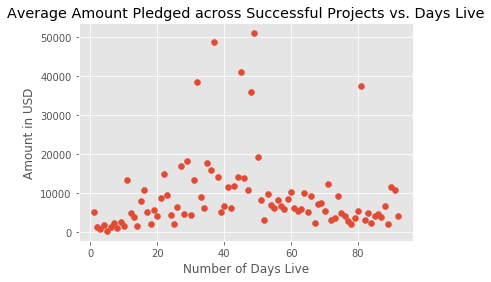

Day 01 --> $    185.73 pledged
Day 02 --> $   1590.00 pledged
Day 03 --> $   8581.24 pledged
Day 04 --> $   7146.00 pledged
Day 05 --> $   1205.00 pledged
Day 06 --> $    192.95 pledged
Day 07 --> $   1531.00 pledged
Day 08 --> $   1405.00 pledged
Day 09 --> $    702.00 pledged
Day 10 --> $   2708.00 pledged
Day 11 --> $   2100.00 pledged
Day 12 --> $   3520.00 pledged
Day 13 --> $   2840.30 pledged
Day 14 --> $   1122.89 pledged
Day 15 --> $    250.00 pledged
Day 16 --> $   2282.32 pledged
Day 17 --> $    754.82 pledged
Day 18 --> $   1145.00 pledged
Day 19 --> $  23079.00 pledged
Day 20 --> $   1205.00 pledged
Day 21 --> $    376.94 pledged
Day 22 --> $   1540.00 pledged
Day 23 --> $  11001.00 pledged
Day 24 --> $    711.71 pledged
Day 25 --> $  61365.16 pledged
Day 26 --> $  26407.00 pledged
Day 27 --> $   1072.00 pledged
Day 28 --> $ 121857.33 pledged
Day 29 --> $  10046.00 pledged
Day 30 --> $  12700.00 pledged
Day 31 --> $  47266.00 pledged
Day 32 --> $    850.00 pledged
Day 33 -

In [26]:
plt.scatter(xvals_live, yvals_pledged)
plt.title("Average Amount Pledged across Successful Projects vs. Days Live")
plt.ylabel("Amount in USD")
plt.xlabel("Number of Days Live")
plt.show()

for i in range(1, 93):
    print("Day {:02} --> ${:10.2f} pledged".format(live[live.index(i)], pledges[live.index(i)]))

This is just a small example of the information we can find from our data by partitioning it. Further examples follow in the Data Analysis below:

<a id='vis_data'></a>
# Data Visualization/Analysis

We wanted to look at the following metrics to gain more insight into the noisy data, apart from what we discovered when training the classifier. We looked at <b>all</b> projects, <b>successful</b> projects, and <b> failed </b> projects.

Data calculated and visualized:
    1. Average amount pledged per backer.
    2. Average number of backers per project.
    3. Average pledged for each category.
    4. Average pledged for amount of days live.
    5. Success rate of projects per category.
    6. Proportion of goal contributed by average backer.
    7. Proportion of goal contributed by average backer per category.

### 1. Average amount pledged per backer

In [27]:
number_suc_backers = 0
number_fail_backers = 0
num_backers = 0
pledged_suc = 0
pledged_fail = 0
pledged = 0

for ind, r in df.iterrows():
    if r['state'] == 'successful':
        number_suc_backers += r['backers']
        pledged_suc += r['usd_pledged_real']
    elif r['state'] == 'failed':
        number_fail_backers += r['backers']
        pledged_fail += r['usd_pledged_real']
    num_backers += r['backers']
    pledged += r['usd_pledged_real']

In [28]:
print("Average amount pledged per backer --> All projects: $%0.3f\t Successful: $%0.3f\t Failed: $%0.3f" %(\
     pledged/num_backers,\
     pledged_suc/number_suc_backers,\
     pledged_fail/number_fail_backers))

Average amount pledged per backer --> All projects: $85.438	 Successful: $85.900	 Failed: $80.415


This is interesting data. It shows that successful have an average of about the same as the average one. However, we will return to this once when we divide by category.

### 2. Average backers for projects

The data here shows us that successful projects have on average 264 backers while failed projects have 16. This seems to show us that projects with more backers that each give less money is a more effective model than less backers that each give more money.

Thus <b>Backers are strongly related to the success of a project</b>.

In [29]:
total_backers = 0
num_successful_backers = 0
num_failed_backers = 0
num_projects_succeeded = 0
num_projects_failed = 0
total_projects = 0

for ind, r in df.iterrows():
    if r['state'] == 'successful':
        num_successful_backers += r['backers']
        num_projects_succeeded += 1
    elif r['state'] == 'failed':
        num_failed_backers += r['backers']
        num_projects_failed += 1
    total_backers += r['backers']
    total_projects += 1

In [30]:
print("Amount pledged per day, in USD:\n Averaged over all projects: $%0.3f\n Averaged over successful projects: $%0.3f\n Averaged over failed projects: $%0.3f" %(\
     num_backers/total_projects,\
     num_successful_backers/num_projects_succeeded,\
     num_failed_backers/num_projects_failed))

Amount pledged per day, in USD:
 Averaged over all projects: $116.382
 Averaged over successful projects: $263.921
 Averaged over failed projects: $16.422


### 3. Average pledged for each category

In this graph, we showed what the average amount of money pledged for each category was overall, in successful projects, and in failed projects.
 

In [31]:
category_averages = {}
category_averages_success = {}
category_averages_fails = {}
l = [category_averages, category_averages_fails, category_averages_success]

for d in l:
    for key in df['main_category'].unique():
        d[key] = [0, 0]

for ind, r in df.iterrows():
    category = r['main_category']
    category_averages[category][0] += r['usd_pledged_real']
    category_averages[category][1] += 1
    if r['state'] == 'successful':
        category_averages_success[category][0] += r['usd_pledged_real']
        category_averages_success[category][1] += 1
    elif r['state'] == 'failed':
        category_averages_fails[category][0] += r['usd_pledged_real']
        category_averages_fails[category][1] += 1

# store the number of projects for each category
cat_frequency = {}
cat_suc_frequency = {}
cat_fail_frequency = {}

for key in category_averages:
    cat_frequency[key] = category_averages[key][1]
    cat_suc_frequency[key] = category_averages_success[key][1]
    cat_fail_frequency[key] = category_averages_fails[key][1]

for d in l:
    for key in d:
        d[key] = d[key][0]/d[key][1]


In [32]:
print("Values for pledged USD based on category:\n" + '-' * 80)
for key in category_averages:
    # populate data for histogram
    print("{:15s}".format(key) ,"avg:\t%0.3f\tsuc:\t%0.3f\tfail:\t%0.3f" % \
          (category_averages[key], category_averages_success[key], category_averages_fails[key]))

Values for pledged USD based on category:
--------------------------------------------------------------------------------
Publishing      avg:	3689.204	suc:	9436.911	fail:	634.687
Film & Video    avg:	6714.662	suc:	13951.872	fail:	1518.801
Music           avg:	4161.739	suc:	7338.132	fail:	628.309
Food            avg:	5567.315	suc:	17349.391	fail:	1077.746
Crafts          avg:	1784.832	suc:	5629.697	fail:	358.936
Games           avg:	25071.629	suc:	54228.755	fail:	2264.099
Design          avg:	27804.649	suc:	62858.524	fail:	2840.536
Comics          avg:	7147.216	suc:	11385.660	fail:	1012.184
Fashion         avg:	6355.440	suc:	20286.556	fail:	861.382
Theater         avg:	4165.408	suc:	5973.135	fail:	979.948
Art             avg:	3474.077	suc:	6971.895	fail:	625.030
Photography     avg:	3892.035	suc:	10111.690	fail:	672.116
Technology      avg:	23976.726	suc:	93085.762	fail:	2408.646
Dance           avg:	3612.684	suc:	5194.016	fail:	619.037
Journalism      avg:	2939.830	suc:	10344.950	fai

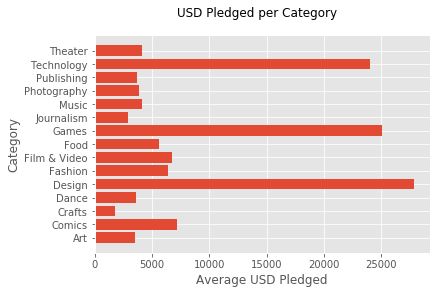

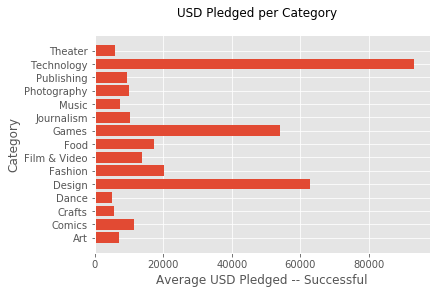

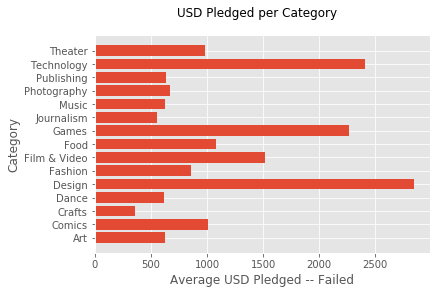

In [33]:
# plot a triple-stacked histogram for this data
# variables for histogram
x  = df['main_category'].unique()
y1 = []
y2 = []
y3 = []

for e in x:
    y1.append((category_averages[e]))
    y2.append((category_averages_success[e]))
    y3.append((category_averages_fails[e]))
    
plt.barh(x, y1)
plt.suptitle("USD Pledged per Category")
plt.ylabel("Category")
plt.xlabel("Average USD Pledged")
plt.show()

plt.barh(x, y2)
plt.suptitle("USD Pledged per Category")
plt.ylabel("Category")
plt.xlabel("Average USD Pledged -- Successful")
plt.show()

plt.barh(x, y3)
plt.suptitle("USD Pledged per Category")
plt.ylabel("Category")
plt.xlabel("Average USD Pledged -- Failed")
plt.show()

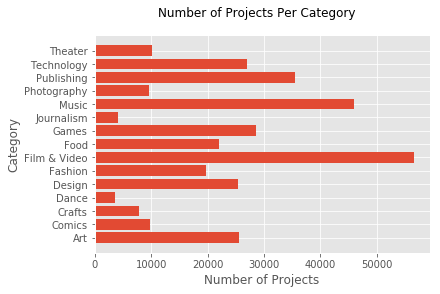

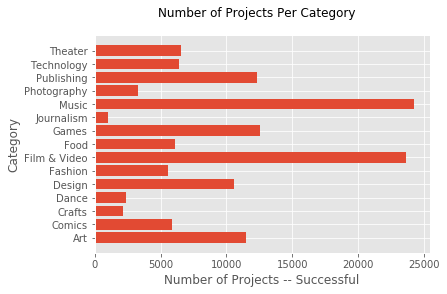

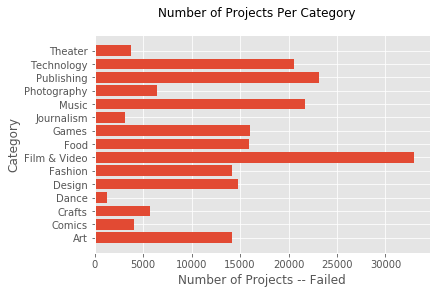

In [34]:
# plot a triple-stacked histogram for this data
# variables for histogram
x  = df['main_category'].unique()
y1 = []
y2 = []
y3 = []

for e in x:
    y1.append(cat_frequency[e])
    y2.append(cat_suc_frequency[e])
    y3.append(cat_fail_frequency[e])
    
plt.barh(x, y1)
plt.suptitle("Number of Projects Per Category")
plt.ylabel("Category")
plt.xlabel("Number of Projects")
plt.show()

plt.barh(x, y2)
plt.suptitle("Number of Projects Per Category")
plt.ylabel("Category")
plt.xlabel("Number of Projects -- Successful")
plt.show()

plt.barh(x, y3)
plt.suptitle("Number of Projects Per Category")
plt.ylabel("Category")
plt.xlabel("Number of Projects -- Failed")
plt.show()

#### Overall
Overall, on average Design projects received the most money at around \$28000, followed by Games projects at around \$25000, and then Technology projects at around \$24000. These categories had significantly more money pledged on average than any of the other categories. The next category after these is Comics projects, which on average receives about \$7000 in pledges. 
    
#### Successful
For the successful projects, Technology projects receive the most pledge money at around \$9500, followed by Design projects at around \$6100, and then Games projects at around \$5200. Once again these categories dwarfed all of the others in terms of how much pledge money they received. The rest of the categories all received \$2000 or less each on average. 
    
#### Failed
For the failed projects, Design projects once again receive the most money at around \$2900, followed by Technology projects at around \$2400, and then Games projects at around \$2200. These categories seem to consistently stand out from the rest in terms of how much money they are receiving.
Theorem: If A and B are similar, then they have the same values
and eigspace(A) has the same dimensions as eigspace(B).

#### Connections
As we have seen, Kickstarter projects in the categories of Technology, Design, and Games tend to receive the most money in pledges on average. An important point to make is that the amount of money each of these categories receives is in no way an indicator that one category is more successful than the other. It is important to understand that different categories of kickstarter projects and just different projects in general require different levels of monetary backing to be successful. One interesting point is that although Design projects receive the most money pledged overall, Technology projects receive the most money pledged for successful projects. This makes sense because a kickstarter project in technology would often require a large amount of monetary support in order to be successful, since new ventures in technology tend to be expensive. 


### 4. Average amount pledged per day that a project was live

Let's look at the average amount pledged per day live.
First, we'll calculate this amount, averaged over all projects (both successful and failed).
Second, we'll look at the amount pledged per day live of all the successful projects.
Finally, we'll look at the amount pledged per day live of all the failed projects.



In [35]:
total_pledged = 0
total_days_live = 0
num_pledged_succeeded = 0
num_days_live_succeeded = 0
num_pledged_failed = 0
num_days_live_failed = 0

for ind, r in df.iterrows():
    if r['state'] == 'successful':
        num_pledged_succeeded += r['usd_pledged_real']
        num_days_live_succeeded += r['days_live']
    elif r['state'] == 'failed':
        num_pledged_failed += r['usd_pledged_real']
        num_days_live_failed += r['days_live']
    total_pledged += r['usd_pledged_real']
    total_days_live += r['days_live']

In [36]:
print("Average pledged for amount of days live --> All projects: %0.3f\t Successful: %0.3f\t Failed: %0.3f" %(\
     total_pledged/total_days_live,\
     num_pledged_succeeded/num_days_live_succeeded,\
     num_pledged_failed/num_days_live_failed))

Average pledged for amount of days live --> All projects: 289.143	 Successful: 695.697	 Failed: 37.085


Here we see that for successful projects, on average \$695 were pledged per day while for failed projects, on average \$37 were pledged per day. This shows that projects are more successful when they earn larger amounts of money over fewer days rather than small amounts of money over a long stretch.

### 5. Success rate for each category

In [37]:
category_total = {}
category_success = {}
l = [category_total, category_success]

for d in l:
    for key in df['main_category'].unique():
        d[key] = [0, 0]

for ind, r in df.iterrows():
    category = r['main_category']
    category_total[category][0] += 1
    if r['state'] == 'successful':
        category_success[category][0] += 1

for d in l:
    for key in d:
        d[key] = d[key][0]


In [38]:
print("Values for pledged USD based on category:\n" + '-' * 80)
for key in category_total:
    print("{:15s}".format(key) ,"Success rate:\t%0.3f%% \t Total Projects:\t%.0f" % \
          ((category_success[key]/category_total[key])*100,category_total[key]))

Values for pledged USD based on category:
--------------------------------------------------------------------------------
Publishing      Success rate:	34.702% 	 Total Projects:	35445
Film & Video    Success rate:	41.791% 	 Total Projects:	56527
Music           Success rate:	52.661% 	 Total Projects:	45949
Food            Success rate:	27.591% 	 Total Projects:	22054
Crafts          Success rate:	27.053% 	 Total Projects:	7818
Games           Success rate:	43.890% 	 Total Projects:	28521
Design          Success rate:	41.594% 	 Total Projects:	25364
Comics          Success rate:	59.142% 	 Total Projects:	9878
Fashion         Success rate:	28.283% 	 Total Projects:	19775
Theater         Success rate:	63.796% 	 Total Projects:	10242
Art             Success rate:	44.889% 	 Total Projects:	25641
Photography     Success rate:	34.111% 	 Total Projects:	9689
Technology      Success rate:	23.786% 	 Total Projects:	27050
Dance           Success rate:	65.435% 	 Total Projects:	3573
Journalism   

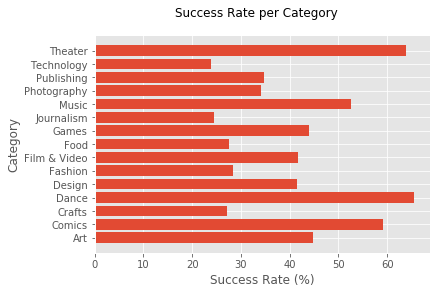

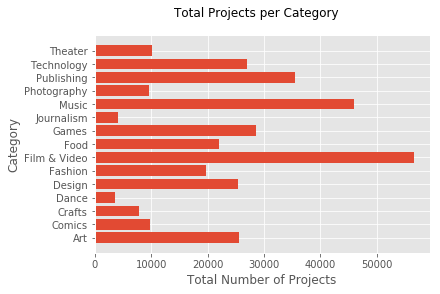

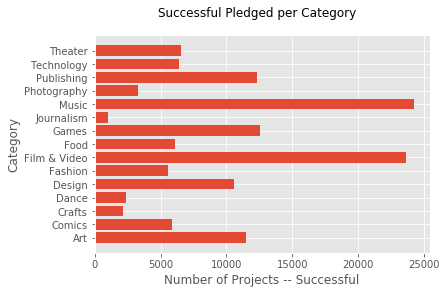

In [39]:
x  = df['main_category'].unique()
y1 = [] 
y2 = [] 
y3 = [] 

for e in x:
    y1.append((category_success[e]/category_total[e])*100)
    y2.append(category_total[e])
    y3.append(category_success[e])
    
plt.barh(x, y1)
plt.suptitle("Success Rate per Category")
plt.ylabel("Category")
plt.xlabel("Success Rate (%)")
plt.show()

plt.barh(x, y2)
plt.suptitle("Total Projects per Category")
plt.ylabel("Category")
plt.xlabel("Total Number of Projects")
plt.show()

plt.barh(x, y3)
plt.suptitle("Successful Pledged per Category")
plt.ylabel("Category")
plt.xlabel("Number of Projects -- Successful")
plt.show()

Looking at the success rate for each category, we find that Dance and Theater kickstarters have the highest success rate, at around 65% and 63% respectively. They are then followed by Comics kickstarters with a 59% success rate. This seems counter intuitive because when thinking of kickstarters we generally think more about technology related projects and things more in that realm but here we find that Dance and Theater instead seem to be the most successful, both categories that are usually seen as more low reward ventures. Although, when we look at the amount of total projects in each of these categories in the graph below this, we find that all of these categories have a relatively low number of projects, which may explain why their success rate is on the relatively higher side. Dance, Theater, and Comics all have around 1000 or less total projects. The smaller sample size is what may be causing their seeming success. But, looking at the next highest success rate, which is Music kickstarters with about a 52% success rate, we find that this category has over 4500 projects, so the success rate found here may be more valid. Even with this larger number of projects, this category of project still has such a high success rate. 

When we go back and compare this data with the data for the average pledged for each country there are some interesting conclusions to be drawn. In the previous section we found that in successful projects, Technology projects receive the the most pledge money on average, around \$95000, and in this section we found that Technology has the lowest success rate of all the categories, at about 22%. While on the other hand, Dance, which has the highest success rate here, receives around \$5000 on average for a successful project, which is significantly lower than than of a Technology project. Looking at the next 3 most successful categories, Dance, Theater, and Comics, all of these categories have an average pledge value under \$10000 when successful, which is once again significantly lower than Technology. Obviously this is not a complete correlation because the Games category, which has a success rate of about 43%, and the Design category, which has a success rate of about 41%, had average pledged values of about \$55000 and \$61000 for successful projects, which are much higher than all of the other categories expect Technology. But regardless it seems that projects that need less money overall, such as Dance, Theater, and Comics, tend to succeed more. This makes a lot of sense because lower goals are more attainable. 


### 6. Average Proportion of Goal contributed by Backer

In [40]:
prop_success_total = 0
prop_fail_total = 0
prop_total = 0
num_success = 0
num_fail = 0
num_total = 0

category_total = {}
category_success = {}
category_fail = {}

l = [category_total, category_success, category_fail]

for d in l:
    for key in df['main_category'].unique():
        d[key] = [0, 0]

for ind, r in df.iterrows():
    number_backers = r['backers']
    pledged = r['usd_pledged_real']
    if (number_backers != 0):
        avg_pledged = pledged/number_backers
    else:
        avg_pledged = 0
    goal = r['usd_goal_real']
    prop = avg_pledged/goal
    
    #update proportion total numbers
    prop_total += prop
    num_total += 1
    if r['state'] == 'successful':
        prop_success_total += prop
        num_success += 1
    elif r['state'] == 'failed':
        prop_fail_total += prop
        num_fail += 1
        
    #update category numbers
    category = r['main_category']
    category_total[category][0] += prop
    category_total[category][1] += 1
    if r['state'] == 'successful':
        category_success[category][0] += prop
        category_success[category][1] += 1
    elif r['state'] == 'failed':
        category_fail[category][0] += prop
        category_fail[category][1] += 1

for d in l:
    for key in d:
        d[key] = (d[key][0]/d[key][1])*100

In [41]:
print("Average proportion of goal contributed by each backer --> \nAll projects: %0.3f%%\tSuccessful: %0.3f%%\tFailed: %0.3f%%" %(\
     (prop_total/num_total)*100,\
     (prop_success_total/num_success)*100,\
     (prop_fail_total/num_fail)*100))

Average proportion of goal contributed by each backer --> 
All projects: 6.174%	Successful: 13.843%	Failed: 0.977%


We find here that in successful projects, on average each backer contributes about 14% of the goal. This implies that usually when a kickstarter succeeds, each backer contributes a significant amount of the total goal. This refutes the idea that a kickstarter is successful when there are a large number of backers each giving a small amount of money. It seems that a kickstarter is more successful when there a smaller number of backers each giving a significant amount.


### 7. Average proportion of goal contributed by backer in each category

In [42]:
print("Values for pledged USD based on category:\n" + '-' * 80)
for key in category_total:
    print("{:15s}".format(key) ,"Overall:\t%0.3f%%\t Successful:\t%0.3f%%\t Failed:\t%0.3f%%" % \
          (category_total[key],category_success[key],category_fail[key]))

Values for pledged USD based on category:
--------------------------------------------------------------------------------
Publishing      Overall:	4.635%	 Successful:	11.505%	 Failed:	0.984%
Film & Video    Overall:	5.773%	 Successful:	12.563%	 Failed:	0.899%
Music           Overall:	8.792%	 Successful:	15.712%	 Failed:	1.095%
Food            Overall:	3.444%	 Successful:	10.309%	 Failed:	0.827%
Crafts          Overall:	5.094%	 Successful:	14.434%	 Failed:	1.630%
Games           Overall:	4.807%	 Successful:	9.991%	 Failed:	0.752%
Design          Overall:	2.965%	 Successful:	5.949%	 Failed:	0.839%
Comics          Overall:	17.258%	 Successful:	28.431%	 Failed:	1.085%
Fashion         Overall:	3.315%	 Successful:	8.935%	 Failed:	1.098%
Theater         Overall:	5.832%	 Successful:	8.421%	 Failed:	1.268%
Art             Overall:	13.660%	 Successful:	28.492%	 Failed:	1.580%
Photography     Overall:	3.522%	 Successful:	7.832%	 Failed:	1.290%
Technology      Overall:	4.252%	 Successful:	16.208%

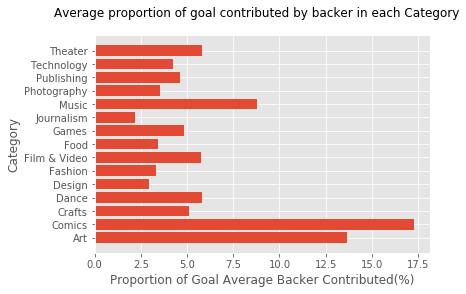

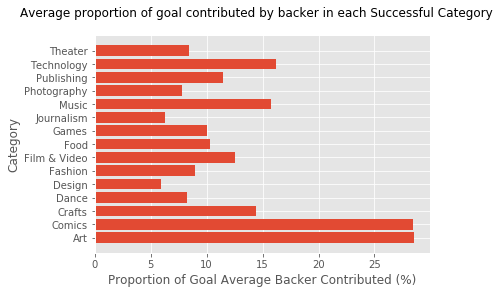

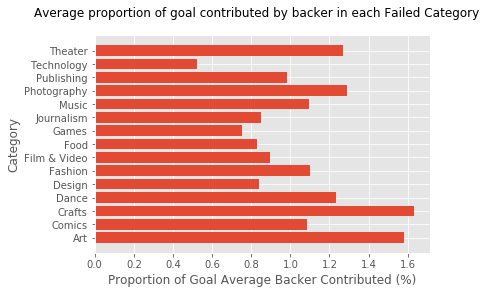

In [43]:
x  = df['main_category'].unique()
y1 = [] 
y2 = [] 
y3 = [] 

for e in x:
    y1.append(category_total[e])
    y2.append(category_success[e])
    y3.append(category_fail[e])
    
plt.barh(x, y1)
plt.suptitle("Average proportion of goal contributed by backer in each Category")
plt.ylabel("Category")
plt.xlabel("Proportion of Goal Average Backer Contributed(%)")
plt.show()

plt.barh(x, y2)
plt.suptitle("Average proportion of goal contributed by backer in each Successful Category")
plt.ylabel("Category")
plt.xlabel("Proportion of Goal Average Backer Contributed (%)")
plt.show()

plt.barh(x, y3)
plt.suptitle("Average proportion of goal contributed by backer in each Failed Category")
plt.ylabel("Category")
plt.xlabel("Proportion of Goal Average Backer Contributed (%)")
plt.show()


In successful projects, in the Comics and Art categories backers contribute on average about 25% of the goal. Overall these categories seem to have backers contributing the highest proportion of the goal. This makes sense considering in our previous analysis we found that these categories on average needed less money in order to succeed, both needing less than $10000 on average. One interesting find is that in successful projects for Design, backers contribute on average about 5% of the goal. This makes sense because Design projects tend to need a lot more monetary support overall. But, though Technology projects also need a lot of monetary support, in successful projects, each backer on average contributes about 15% of the goal, which is a significant amount.


<a id='ethics'></a>
## Privacy/Ethics Considerations

---
Most ethical and privacy concerns that could stem from analyzing public data in a project like ours are addressed by the dataset we are using, which has taken care of these concerns before publishing the data.

##### Permission
We have permission from the person who collected and published this dataset to use this data for this purpose. The collector of the data specifically mentions a desire to see the data be used for a project like ours that seeks to create a model for predicting the success/failure of projects on Kickstarter. All of the information in the dataset is based on the publicly available information of each project on the Kickstarter website, so there is no issue of conflict regarding permission to use this data from the project owners.

##### Privacy
This is freely/publicly available, pre-anonymized public data.This dataset only contains an ID associated with each project, the name of the project, the subcategory and category of the project, the currency and country the project is based in, the project deadline, goal amount to be raised, launch date, amount of money that was pledged, whether or not the project was successful, and the number of backers for the project. Using the Safe Harbor method on our dataset, we determined that none of these categories are concerns for privacy:
- _Names of individuals_: None - we have names of the projects, but they cannot be used to identify the owners of these projects.
- _Geographic Subdivisions smaller than a state_: None
- _Dates (such as birth dates, etc), and all ages above 90_: None
- _Telephone Numbers_: None
- _Vehicle Identification Numbers_: None
- _Fax numbers_: None
- _Device identifiers and serial numbers_: None
- _Email addresses_: None
- _Web Universal Resource Locators (URLs)_: None
- _Social security numbers_: None
- _Internet Protocol (IP) addresses_: None
- _Medical record numbers_: None
- _Biometric identifiers, including finger and voice prints_: None
- _Health plan beneficiary numbers_: None
- _Full-face photographs and any comparable images_: None
- _Account numbers_: None
- _Certificate/license numbers_: None
- _Any other unique identifying number, characteristic, or code_: None - the ID used in the data set is unique but cannot identify the owner of the project, but simply the project name. We are keeping this field as we, in future, can tmerge a different kickstarter dataset, having more columns about the same projects, using the ID as the merging field.

##### Biases
There are no obvious biases in the data itself, as it is composed of all the projects that have been started on Kickstarter until January 2018, without any biased deletion of project data from the public dataset- we have cleaned the data to remove some noise (such as suspended projects), so any such bias that may prevent equitable analysis is accounted for in this data cleaning. It should be noted that for a kickstarter there are a lot of variables that go into play -- for example publicity, the need of the particular product in that time, people willing to spend money on that category, etc. This classifier does not take into account those factors, and relies purely on a statistical approach, however, this is made clear in the hypothesis itself which seeks to see if such a classifier could be accurate enough to predict kickstarter fundraising success.

##### Other issues
There are no other issues related to our topic area, data, and/or analyses that are potentially problematic in terms of data privacy and equitable impact. Kickstarter is a public platform so analyzing and using data from this platform does not run into common concerns of data privacy. 


<a id='closing'></a>
## Conclusions & Discussion
---

#### Conclusions Directly Drawn From Data
It is not easy to make a classifier that predicts the success of a Kickstarter project with reasonable (>70%) accuracy, as our classifier was only 61% accurate. This indicates that there are probably other factors significantly affecting the success of a Kickstarter project beyond simply the goal amount and days the project is live. Some such nonquantifiable factors include the professionalism and presentation of the project (does it look to potential backers like it would be successful?), the uniqueness of the idea, the presence of a prototype/previous examples of success that would give backers the confidence that this project would be successful, and the marketing of the project to the public. 

However, some factors that significantly influence (or do not influence) the success of a project are quantifiable and were determined with our analysis to be the following: 
- More backers significantly define the success of a project, as most successful projects seem to have many backers contributing a moderate amount.
- More money in a cotegory does not mean projects will be more successful. Ex. Design has more money overall, but Tech has the most money in successful projects.
- Number of days live does not seem to very significantly affect funding. Longer project durations are mostly associated with higher goals, but not related to success.
- Projects with lower goals tend to be more successful.
- The category you are trying for does not need to be "hot" to get funding. Theater, Dance and Comics have the three highest success rates but these all have relatively low numbers of total projects. 
- Each backer contributes 14% of goal in successful on average. However, this varies from (5-15% by category, look at graph).
- Kickstarter projects are more successful with smaller number of backers, each of who give a significant amount.

#### Future Inquiry
This data was interesting to analyze, but at the same time, frustratingly hard to quantify. Although we had access to a lot of data, it is not very well suited for predictive analysis, because the indicators in the data do not really correlate to the success of a project.

This does not imply, in any sense, that the findings here are any less significant. We have worked to isolate the fundamentals of success on Kickstarter, and the visualizations highlight the fact that there are counterintuitive dichotomies in the data. For example, there is little to no correlation between days live and success, whereas people would expect a longer project to receive more funding.

However, we can augment the project and do further analysis if we use other databases and webcrawler data [like so](https://webrobots.io/kickstarter-datasets/), which indexes and has IDs for projects (allowing us to merge the dataframes using pandas). For example, we could train a deep-learning NLP model on the project blurbs to feed into the classifier. Thus, it will be able to identify buzzwords that may be common to successful projects.

Overall, this project was pretty successful and we determined that our hypothesis about being able to predict Kickstarter projects with > 70% accuracy was not correct, but we did learn about which factors significantly do and do not affect the success of a Kickstarter project.